# FINAL PROJECT: SIMPLE APPROACH STACK WITH LGBM AND LINREG

You can find all the data in `../readonly/final_project_data` folder or download it from [Kaggle](https://inclass.kaggle.com/c/competitive-data-science-final-project) if you are solving locally. 

**Good luck!**

# Competition description

This challenge serves as final project for the _"How to win a data science competition"_ Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - __1C Company__.

We are asking you to __predict total sales for every product and store in the next month__. By solving this competition you will be able to apply and enhance your data science skills.

### Submission File

For each id in the test set, you must predict a total number of sales. The file should contain a header and have the following format:

`ID,item_cnt_month
0,0.5
1,0.5
2,0.5
3,0.5
etc.`

### Team Limits

Three individuals.

### Submission Limits

You may submit a maximum of 5 entries per day (10 for Coursera).

### Metric

Submissions are evaluated by root mean squared error (__RMSE__). True target values are clipped into [0,20] range.

In [1]:
target_range = [0, 20]

### Leaderboard
By now lowest RMSE in PL is: `0.79215`
with `210` submissions

# Imports

In [1]:
import torch

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

import os, gc, math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

from itertools import product

import lightgbm as lgb
from sklearn import feature_extraction
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import scipy.sparse 

from tqdm import tqdm, tqdm_notebook
tqdm.monitor_interval = 0

import data
from data import index_cols, index_cols_shop, future_index_cols
import features
import tools
from models import rmse_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sklearn
for p in [np, pd, sklearn, scipy]:
    print (p.__name__, p.__version__)

numpy 1.13.1
pandas 0.20.3
sklearn 0.19.0
scipy 0.19.1


# Load features

Preprocessed, from disk.

In [6]:
all_data = features.load_features()

# Check
data.inspect_dataframe('ALL_DATA', all_data)


ALL_DATA (6639294, 44)
shop_id                       int32
item_id                       int32
date_block_num                int32
target                      float32
revenue                     float32
target_shop                 float32
revenue_per_shop            float32
target_item                 float32
revenue_per_item            float32
item_category_id              int32
target_category             float32
revenue_per_category        float32
target_item_price           float32
item_category_id_enc        float32
target_lag_1                float32
target_lag_2                float32
target_lag_3                float32
target_lag_4                float32
target_lag_5                float32
target_lag_12               float32
target_shop_lag_1           float32
target_shop_lag_2           float32
target_shop_lag_3           float32
target_shop_lag_4           float32
target_shop_lag_5           float32
target_shop_lag_12          float32
target_item_lag_1           float32
targ

,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,...,target_category_lag_3,target_category_lag_4,target_category_lag_5,target_category_lag_12,target_item_price_lag_1,target_item_price_lag_2,target_item_price_lag_3,target_item_price_lag_4,target_item_price_lag_5,target_item_price_lag_12
4488756,2,27,12,0.0,0.0,890.0,1032722.0,1.0,998.0,19,...,14113.0,18932.0,10488.0,8983.0,1048.000000,1198.000000,942.266663,1198.0,1198.000000,2325.0
4488757,2,30,12,0.0,0.0,890.0,1032722.0,58.0,9802.0,40,...,24173.0,23348.0,24130.0,0.0,167.330856,165.217392,205.524994,399.0,384.894745,0.0
4488758,2,31,12,0.0,0.0,890.0,1032722.0,15.0,7485.0,37,...,6950.0,7659.0,8680.0,0.0,499.000000,488.377777,543.528015,699.0,688.400024,0.0


,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,...,target_category_lag_3,target_category_lag_4,target_category_lag_5,target_category_lag_12,target_item_price_lag_1,target_item_price_lag_2,target_item_price_lag_3,target_item_price_lag_4,target_item_price_lag_5,target_item_price_lag_12
11128047,59,22164,34,0.0,0.0,0.0,0.0,0.0,0.0,37,...,3426.0,3291.0,3756.0,0.0,549.000000,549.0,631.5,699.0,699.000000,0.0
11128048,59,22166,34,0.0,0.0,0.0,0.0,0.0,0.0,54,...,264.0,276.0,292.0,305.0,150.000000,150.0,150.0,150.0,150.000000,150.0
11128049,59,22167,34,0.0,0.0,0.0,0.0,0.0,0.0,49,...,571.0,669.0,699.0,760.0,293.895935,299.0,299.0,299.0,294.636353,299.0


# Data split

The dataset has a timeline, get last month of train as validation data.

And the month=34 is the X_test for final submission.

In [8]:
X_train, y_train, dates_train, X_val, y_val, dates_val, X_test, y_test, dates_test = data.split_and_dates(all_data)

Test data is where date_block_num=34
Validation data is where date_block_num=33

fit_cols: ['item_category_id', 'item_category_id_enc', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_4', 'target_lag_5', 'target_lag_12', 'target_shop_lag_1', 'target_shop_lag_2', 'target_shop_lag_3', 'target_shop_lag_4', 'target_shop_lag_5', 'target_shop_lag_12', 'target_item_lag_1', 'target_item_lag_2', 'target_item_lag_3', 'target_item_lag_4', 'target_item_lag_5', 'target_item_lag_12', 'target_category_lag_1', 'target_category_lag_2', 'target_category_lag_3', 'target_category_lag_4', 'target_category_lag_5', 'target_category_lag_12', 'target_item_price_lag_1', 'target_item_price_lag_2', 'target_item_price_lag_3', 'target_item_price_lag_4', 'target_item_price_lag_5', 'target_item_price_lag_12'] 32 

train validation test total
6186922 238172 214200 6639294
6186922 238172 214200 6639294


# MODEL
The stacking is the selected approach, combine two 1-st level models (LR and LGB) with a 2-nd level simple model (LinearConvexMix or LinearRegressor)

## 1. Fit first level models

The features will be created using the lectures f) KFold scheme in ime series, with T=1_month and M=Total_months-6.

Split the train data into chunks of duration T. Select first M chunks.
Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. 

After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.

Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.

### 1.1 Train meta features
The six last months are the chunks for folding.

In [33]:
last_blocks = [27, 28, 29, 30, 31, 32]
dates_train_level2 = dates_train[dates_train.isin(last_blocks)]

In [34]:
# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(last_blocks)]

# And here we create 2nd level feature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in last_blocks:
    
    print("\nBlock",cur_block_num,"\n")

        # define the block training data

    X_block_train = X_train.loc[dates_train <  cur_block_num]
    y_block_train = y_train[dates_train < cur_block_num]
    X_block_val = X_train[dates_train == cur_block_num]
    y_block_val = y_train[dates_train == cur_block_num]
    
        # fit models for data block and get predictions
        
    lr_model = models.modelLR(target_range)
    lr_model.fit(X_block_train,y_block_train)
    lr_model.scoring(X_block_val, y_block_val, X_block_train, y_block_train)
    pred_lr = lr_model.predict(X_block_val)

    lgb_model = models.modelLGB(target_range)
    lgb_model.fit(X_block_train,y_block_train)
    lgb_model.scoring(X_block_val, y_block_val, X_block_train, y_block_train)
    pred_lgb = lgb_model.predict(X_block_val)

    print("")
    del(lr_model)
    del(lgb_model)
    res = gc.collect()
    
        # store predictions in X_train_level2
    X_train_level2[dates_train_level2 == cur_block_num] = np.c_[pred_lr, pred_lgb] 
    
print(X_train_level2.shape)
print(X_train_level2[:3])


Block 27 R-squared for linreg is 0.047435
Block 27 RMSE for linreg is 4.481420
Block 27 R-squared for LightGBM is 0.054423
Block 27 RMSE for LightGBM is 4.464951

Block 28 R-squared for linreg is 0.081187
Block 28 RMSE for linreg is 3.672680
Block 28 R-squared for LightGBM is 0.091258
Block 28 RMSE for LightGBM is 3.652497

Block 29 R-squared for linreg is 0.206967
Block 29 RMSE for linreg is 2.073718
Block 29 R-squared for LightGBM is 0.222701
Block 29 RMSE for LightGBM is 2.053044

Block 30 R-squared for linreg is 0.219454
Block 30 RMSE for linreg is 1.889633
Block 30 R-squared for LightGBM is 0.230065
Block 30 RMSE for LightGBM is 1.876744

Block 31 R-squared for linreg is 0.217196
Block 31 RMSE for linreg is 1.978145
Block 31 R-squared for LightGBM is 0.231048
Block 31 RMSE for LightGBM is 1.960565

Block 32 R-squared for linreg is 0.042428
Block 32 RMSE for linreg is 6.700978
Block 32 R-squared for LightGBM is 0.050720
Block 32 RMSE for LightGBM is 6.671900


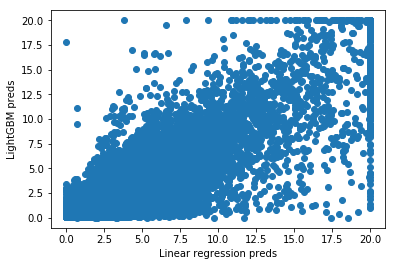

In [35]:
# Check if the 1st level models are uncorrelated enough
plt.scatter(X_train_level2[:,0],X_train_level2[:,1],)
plt.xlabel('Linear regression preds')
plt.ylabel('LightGBM preds')
plt.show()

They seem to be quite correlated :-(

### 1.2 Validation meta features
Create meta features for the validation data (last month of train data).

In [37]:
   # fit models and create the predictions

lr_model = models.modelLR(target_range)
lr_model.fit(X_train, y_train)
lr_model.scoring(X_val, y_val, X_train, y_train)
pred_lr = lr_model.predict(X_val)
print("")

lgb_model = models.modelLGB(target_range)
lgb_model.fit(X_train, y_train)
lgb_model.scoring(X_val, y_val, X_train, y_train)
pred_lgb = lgb_model.predict(X_val)
print("")

     # concatenate predictions to get the meta features

X_val_level2 = np.c_[pred_lr, pred_lgb] 
print(X_val_level2.shape)
print(X_val_level2[:3])

Test R-squared for linreg is 0.044280
Test RMSE for linreg is 5.223112
Test R-squared for LightGBM is 0.048001
Test RMSE for LightGBM is 5.212934
(238172, 2)
[[ 0.02573355  0.04305068]
 [ 0.07017894  0.08470023]
 [ 0.46088907  0.26650834]]


## 2. Stack the models

Test two options.

### 2.1. Check linear convex mix
Simple linear convex mix:

    mix=α⋅linreg_prediction+(1−α)⋅lgb_prediction
 
Fit it finding an optimal  α

In [41]:
alphas_to_try = np.linspace(0, 1, 1001)

def lcmix_predict(X, alpha):
    return alpha*X[:,0] + (1-alpha)*X[:,1]

best_alpha = -1
r2_train_simple_mix = -1e10
for alpha in alphas_to_try:
    lcmix_preds = lcmix_predict(X_train_level2, alpha)
    lcmix_preds = lcmix_preds.clip(*target_range)
    r2 = r2_score(y_train_level2, lcmix_preds)
    if r2 > r2_train_simple_mix:
        best_alpha = alpha
        r2_train_simple_mix = r2

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.000000; Corresponding r2 score on train: 0.084125


In [43]:
# The score that should be near to the one in the LeaderBoard (I hope so)
lcmix_preds = lcmix_predict(X_val_level2, best_alpha)
print('Dev R-squared for simple mix is %f' % r2_score(y_val, lcmix_preds))
print('Dev RMSE for simple mix is %f' %  rmse_score(y_val.clip(*target_range), lcmix_preds))

Validation R-squared for simple mix is 0.048001
Validation RMSE for simple mix is 5.212934


ALPHA IS ZERO so selects only the LGBM ??? Better alone ???

### 2.1 Check linear regression

Check a linear regression as 2nd level model.

In [46]:
# Create model
lr_model = models.modelLR(target_range)
lr_model.fit(pd.DataFrame(X_train_level2), y_train_level2)

# The score that should be near to the one in the LeaderBoard (I hope so)
lr_model.scoring(pd.DataFrame(X_val_level2), y_val, pd.DataFrame(X_train_level2), y_train_level2)

Train R-squared for stacking is 0.076469
Train RMSE for stacking is 3.879571


## 3. Predictions for submission
Fit the 1-st models with all available labeled data and predict on test data with the 2-nd model (linear mix, the best one) for later submission.

In [ ]:
    # prepare all data

X_all = X_train.append(X_val)
y_all = np.concatenate([y_train, y_val])
print(len(X_all),len(y_all),len(X_test),'\n')

    # fit 1-st level models and create the predictions

lr_model = models.modelLR(target_range)
lr_model.fit(X_all,y_all)
pred_lr = lr_model.predict(X_test)
print(len(pred_en),"\n")

lgb_model = models.modelLGB(target_range)
lgb_model.fit(X_all,y_all)
pred_lgb = lgb_model.predict(X_test)
print(len(pred_lgb),"\n")

     # concatenate predictions to get the meta features for stacking

X_all_level2 = np.c_[pred_lr, pred_lgb] 
print(X_all_level2.shape)

     # and get the submission preds
submission_preds = lcmix_predict(X_all_level2, best_alpha)

# SUBMISSION

In [ ]:
del(X_train)
del(X_test)
del(y_train)
del(y_test)
gc.collect()

In [ ]:
#Load test data to merge ID for submission

#DATA_FOLDER = "../input" # en kernel de kaggle
#DATA_FOLDER = "../readonly/final_project_data" # en coursera
DATA_FOLDER = "./data"
#print(os.listdir(DATA_FOLDER))

test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

In [ ]:
# Create submission dataframe
submission = data.create_submission_dataframe(submission_preds, all_data, test)

In [ ]:
# Dump to file
submission_columns = ['ID','item_cnt_month']
submission_filename = './submissions/submission_stacking_lgb+lr_with_lcmix.csv'
submission[submission_columns].to_csv(submission_filename,header=True,index=False)

In [70]:
tools.head_and_tail_file(submission_filename,N=3)

ID,item_cnt_month

0,0.41679683277549334

1,0.5365590824990486

2,0.828664788164847

[...]

214197,0.04725981586629935

214198,0.04321678106605695

214199,0.04321678106605695

TOTAL lines: 214201 ( 214201 )


# Future work

Because of a lack of time I have left behind some aspects that could improve the solution:

* Use text data, encoded as n-grams or TF-IDF (more advanced, pretrained word2vec for russian language)
* Include KNN features